### Task 2: Quantitative Analysis of Stock Prices
This notebook performs EDA on stock price data, calculates technical indicators using TA-Lib, and prepares data for correlation analysis with news sentiment.


In [18]:
# -----------------------------
#  Setup paths
# -----------------------------
import sys
from pathlib import Path

# Notebook location
notebook_path = Path().resolve()  # current notebook folder
project_root = notebook_path.parent  # Notebook/ -> project root
src_path = project_root / "src"

# Add to Python path
sys.path.insert(0, str(src_path))
sys.path.insert(0, str(project_root))

print("Notebook path:", notebook_path)
print("Project root:", project_root)
print("SRC path:", src_path)

Notebook path: D:\10Acadamy\Week 1\Task\Predicting-Price-Moves-with-News-Sentiment\notebooks
Project root: D:\10Acadamy\Week 1\Task\Predicting-Price-Moves-with-News-Sentiment
SRC path: D:\10Acadamy\Week 1\Task\Predicting-Price-Moves-with-News-Sentiment\src


In [8]:
import matplotlib.pyplot as plt
import logging
# Custom modules
from fns_project.utils.notebook_bootstrap import (
    cfg, logger, RAW_DIR, INTERIM_DIR, PROCESSED_DIR, FEATURE_DIR, PLOTS_DIR,
    ASSETS, START_DATE, END_DATE
)
from fns_project.analysis.returns import compute_daily_returns
from fns_project.features.indicators import compute_all_indicators
from fns_project.features.volatility import compute_all_volatility
from fns_project.viz.plots import plot_price_with_indicators,plot_macd, plot_rsi
from fns_project.data.loader import load_prices
from fns_project.utils.dates import normalize_timestamps, datetime_to_date
from fns_project.data.preprocess import clean_feature_dataframe

logger = logging.getLogger(__name__)
logger.info("Modules loaded successfully")

2025-11-26 21:59:31,849 [INFO] __main__: Modules loaded successfully


In [9]:
# -----------------------------
# : Load all price data for ASSETS
# -----------------------------
all_prices = {}

for ticker in ASSETS:
    RAW_DIR = (project_root / "data/raw").resolve()
    price_file = RAW_DIR / "prices" / f"{ticker}.csv"

    # Load raw price CSV
    df = load_prices(price_file)


    # Store cleaned DataFrame
    all_prices[ticker] = df
    

    logger.info(f"{ticker}: {len(df)} rows loaded")

# Preview first ticker
df = all_prices[ASSETS[0]]
df.head(5)

2025-11-26 21:59:32,156 [INFO] fns_project.data.loader: Loaded prices (3774 rows) from D:\10Acadamy\Week 1\Task\Predicting-Price-Moves-with-News-Sentiment\data\raw\prices\AAPL.csv
2025-11-26 21:59:32,159 [INFO] __main__: AAPL: 3774 rows loaded
2025-11-26 21:59:32,208 [INFO] fns_project.data.loader: Loaded prices (3774 rows) from D:\10Acadamy\Week 1\Task\Predicting-Price-Moves-with-News-Sentiment\data\raw\prices\AMZN.csv
2025-11-26 21:59:32,211 [INFO] __main__: AMZN: 3774 rows loaded
2025-11-26 21:59:32,263 [INFO] fns_project.data.loader: Loaded prices (3774 rows) from D:\10Acadamy\Week 1\Task\Predicting-Price-Moves-with-News-Sentiment\data\raw\prices\GOOG.csv
2025-11-26 21:59:32,267 [INFO] __main__: GOOG: 3774 rows loaded
2025-11-26 21:59:32,313 [INFO] fns_project.data.loader: Loaded prices (2923 rows) from D:\10Acadamy\Week 1\Task\Predicting-Price-Moves-with-News-Sentiment\data\raw\prices\META.csv
2025-11-26 21:59:32,317 [INFO] __main__: META: 2923 rows loaded
2025-11-26 21:59:32,418 

,date,Close,High,Low,Open,Volume
0,2009-01-02,2.721686,2.730385,2.554037,2.575630,746015200
1,2009-01-05,2.836553,2.884539,2.780469,2.794266,1181608400
2,2009-01-06,2.789767,2.914229,2.770872,2.877641,1289310400
3,2009-01-07,2.729484,2.774170,2.706990,2.753477,753048800
4,2009-01-08,2.780169,2.793666,2.700393,2.712090,673500800


In [10]:
# -----------------------------
# Clean & align feature data for all assets
# -----------------------------

clean_features = {}

for ticker, df in all_prices.items():
    logger.info(f"Cleaning feature set for {ticker}")


    # Clean features
    df_clean = clean_feature_dataframe(
        df,
        date_col="date",
        ffill_limit=5,
        bfill_limit=5,
        drop_all_nan_cols=True,
        drop_partial_nan_rows=True
    )

    clean_features[ticker] = df_clean
    logger.info(f"{ticker}: cleaned shape={df_clean.shape}")

# Preview
clean_features[ASSETS[0]].head()

2025-11-26 21:59:32,762 [INFO] __main__: Cleaning feature set for AAPL
2025-11-26 21:59:32,803 [INFO] __main__: AAPL: cleaned shape=(3774, 5)
2025-11-26 21:59:32,807 [INFO] __main__: Cleaning feature set for AMZN
2025-11-26 21:59:32,853 [INFO] __main__: AMZN: cleaned shape=(3774, 5)
2025-11-26 21:59:32,858 [INFO] __main__: Cleaning feature set for GOOG
2025-11-26 21:59:32,897 [INFO] __main__: GOOG: cleaned shape=(3774, 5)
2025-11-26 21:59:32,902 [INFO] __main__: Cleaning feature set for META
2025-11-26 21:59:32,930 [INFO] __main__: META: cleaned shape=(2923, 5)
2025-11-26 21:59:32,935 [INFO] __main__: Cleaning feature set for MSFT
2025-11-26 21:59:32,976 [INFO] __main__: MSFT: cleaned shape=(3774, 5)
2025-11-26 21:59:32,980 [INFO] __main__: Cleaning feature set for NVDA
2025-11-26 21:59:33,034 [INFO] __main__: NVDA: cleaned shape=(3774, 5)


,Close,High,Low,Open,Volume
date,,,,,
2009-01-02,2.721686,2.730385,2.554037,2.575630,746015200
2009-01-05,2.836553,2.884539,2.780469,2.794266,1181608400
2009-01-06,2.789767,2.914229,2.770872,2.877641,1289310400
2009-01-07,2.729484,2.774170,2.706990,2.753477,753048800
2009-01-08,2.780169,2.793666,2.700393,2.712090,673500800


In [11]:
# -----------------------------
# Compute daily returns
# -----------------------------
for ticker, df in all_prices.items():
    # Compute returns in-place
    df = compute_daily_returns(
        df,
        close_col="Close",
        date_col="date",
        include_log=True,
        fill_na=True
    )
    all_prices[ticker] = df
    logger.info(f"{ticker}: daily returns added, shape={df.shape}")

# Preview last rows of the first ticker
all_prices[ASSETS[0]].tail()

2025-11-26 21:59:33,654 [INFO] __main__: AAPL: daily returns added, shape=(3774, 7)
2025-11-26 21:59:33,796 [INFO] __main__: AMZN: daily returns added, shape=(3774, 7)
2025-11-26 21:59:33,890 [INFO] __main__: GOOG: daily returns added, shape=(3774, 7)
2025-11-26 21:59:33,925 [INFO] __main__: META: daily returns added, shape=(2923, 7)
2025-11-26 21:59:33,955 [INFO] __main__: MSFT: daily returns added, shape=(3774, 7)
2025-11-26 21:59:34,009 [INFO] __main__: NVDA: daily returns added, shape=(3774, 7)


,Close,High,Low,Open,Volume,daily_return,log_return
date,,,,,,,
2023-12-22,191.788757,193.581821,191.164647,193.353962,37149600,-0.005548,-0.005563
2023-12-26,191.243912,192.076049,191.025969,191.798670,28919300,-0.002841,-0.002845
2023-12-27,191.342972,191.689703,189.302247,190.689158,48087700,0.000518,0.000518
2023-12-28,191.768951,192.838849,191.362784,192.323710,34049900,0.002226,0.002224
2023-12-29,190.728775,192.581275,189.936256,192.085953,42672100,-0.005424,-0.005439


In [12]:
# -----------------------------
# Compute technical indicators and volatility metrics
# -----------------------------
all_features = {}

for ticker, df in all_prices.items():
    logger.info(f"Computing indicators for {ticker}")

    # TA-Lib indicators: SMA, EMA, RSI, MACD, Bollinger Bands, ATR, Stochastic
    df_ind = compute_all_indicators(df)

    # Volatility metrics: ATR, rolling volatility, realized volatility
    df_ind = compute_all_volatility(df_ind)

    all_features[ticker] = df_ind
    logger.info(f"{ticker}: indicators computed, shape={df_ind.shape}")

# Preview
all_features[ASSETS[0]].head(5)

2025-11-26 21:59:35,123 [INFO] __main__: Computing indicators for AAPL
2025-11-26 21:59:35,196 [INFO] __main__: AAPL: indicators computed, shape=(3741, 22)
2025-11-26 21:59:35,203 [INFO] __main__: Computing indicators for AMZN
2025-11-26 21:59:35,260 [INFO] __main__: AMZN: indicators computed, shape=(3741, 22)
2025-11-26 21:59:35,264 [INFO] __main__: Computing indicators for GOOG
2025-11-26 21:59:35,331 [INFO] __main__: GOOG: indicators computed, shape=(3741, 22)
2025-11-26 21:59:35,333 [INFO] __main__: Computing indicators for META
2025-11-26 21:59:35,410 [INFO] __main__: META: indicators computed, shape=(2890, 22)
2025-11-26 21:59:35,413 [INFO] __main__: Computing indicators for MSFT
2025-11-26 21:59:35,502 [INFO] __main__: MSFT: indicators computed, shape=(3741, 22)
2025-11-26 21:59:35,509 [INFO] __main__: Computing indicators for NVDA
2025-11-26 21:59:35,593 [INFO] __main__: NVDA: indicators computed, shape=(3741, 22)


,Close,High,Low,Open,Volume,daily_return,log_return,SMA_20,EMA_20,RSI_14,...,MACD_hist_12_26_9,BB_upper,BB_middle,BB_lower,ATR_14,STOCH_K,STOCH_D,ATR_20,ROLL_VOL_20,REAL_VOL_20
date,,,,,,,,,,,,,,,,,,,,,
2009-02-20,2.735183,2.771173,2.669203,2.681199,750316000,0.006178,0.006159,2.829070,2.811611,45.273764,...,-0.035672,3.057689,2.829070,2.600451,0.109861,22.482578,34.444605,NaN,NaN,NaN
2009-02-23,2.607722,2.759177,2.594526,2.748680,786982000,-0.046601,-0.047721,2.826956,2.792193,39.355300,...,-0.045372,3.062827,2.826956,2.591085,0.113775,10.440469,21.092608,NaN,NaN,NaN
2009-02-24,2.706692,2.725886,2.609221,2.622717,807105600,0.037953,0.037250,2.827870,2.784050,45.331284,...,-0.043431,3.061719,2.827870,2.594022,0.114088,13.886946,15.603331,NaN,NaN,NaN
2009-02-25,2.733984,2.786768,2.676701,2.694996,833053200,0.010083,0.010033,2.828515,2.779281,46.885613,...,-0.038772,3.061250,2.828515,2.595780,0.113801,17.849089,14.058834,NaN,NaN,NaN
2009-02-26,2.674901,2.786768,2.668004,2.759176,629868400,-0.021610,-0.021847,2.821003,2.769341,43.971002,...,-0.038077,3.063195,2.821003,2.578810,0.114156,22.377049,18.037695,NaN,NaN,NaN


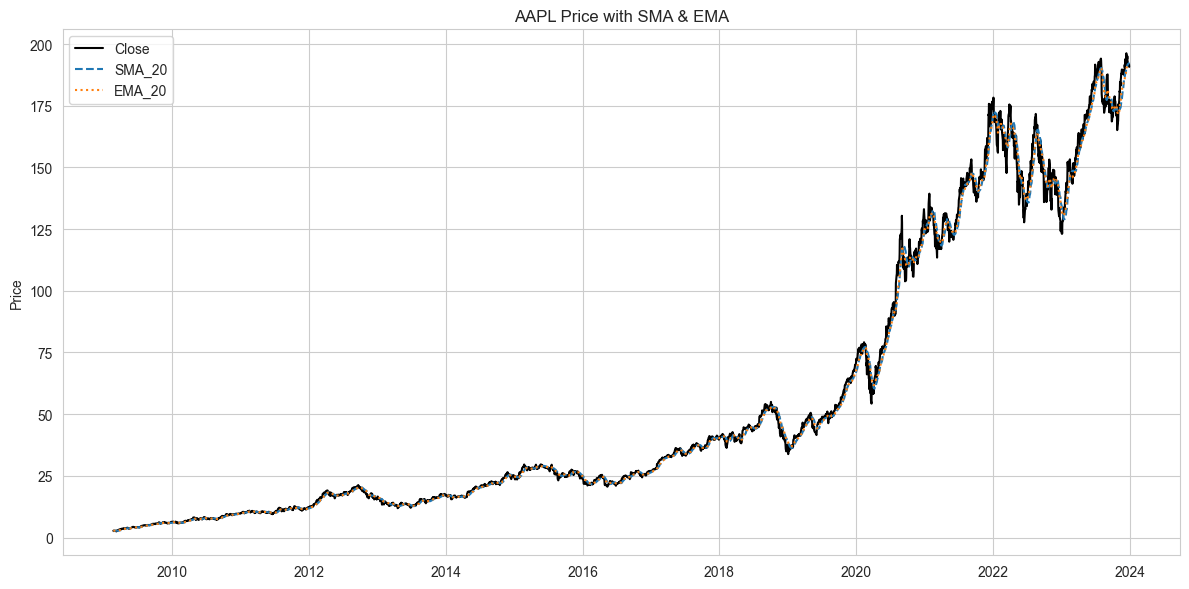

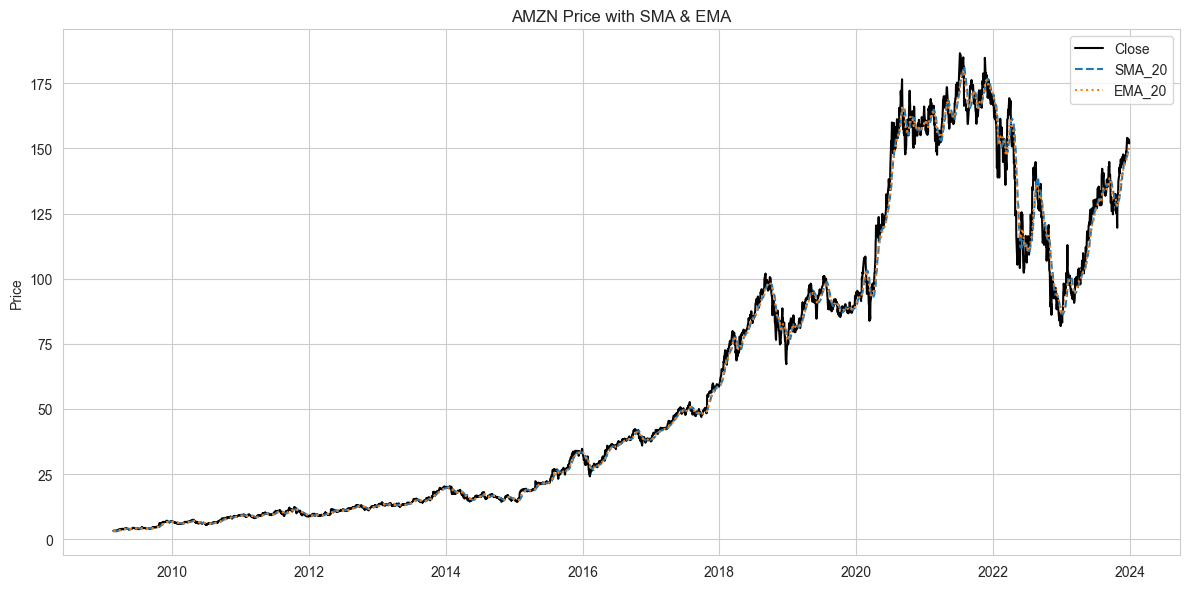

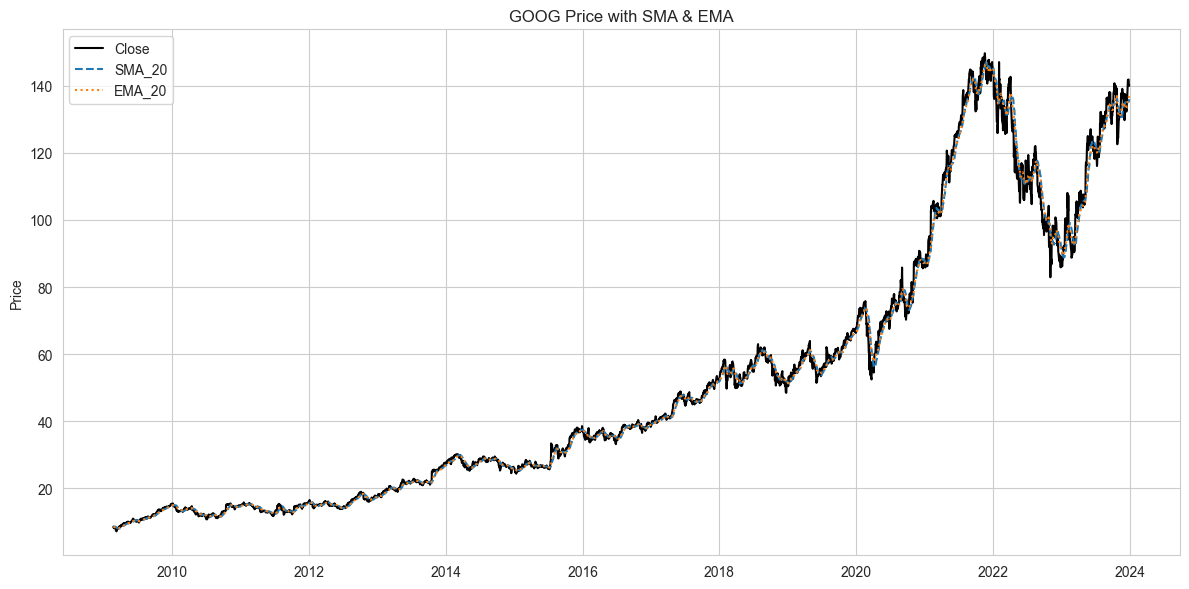

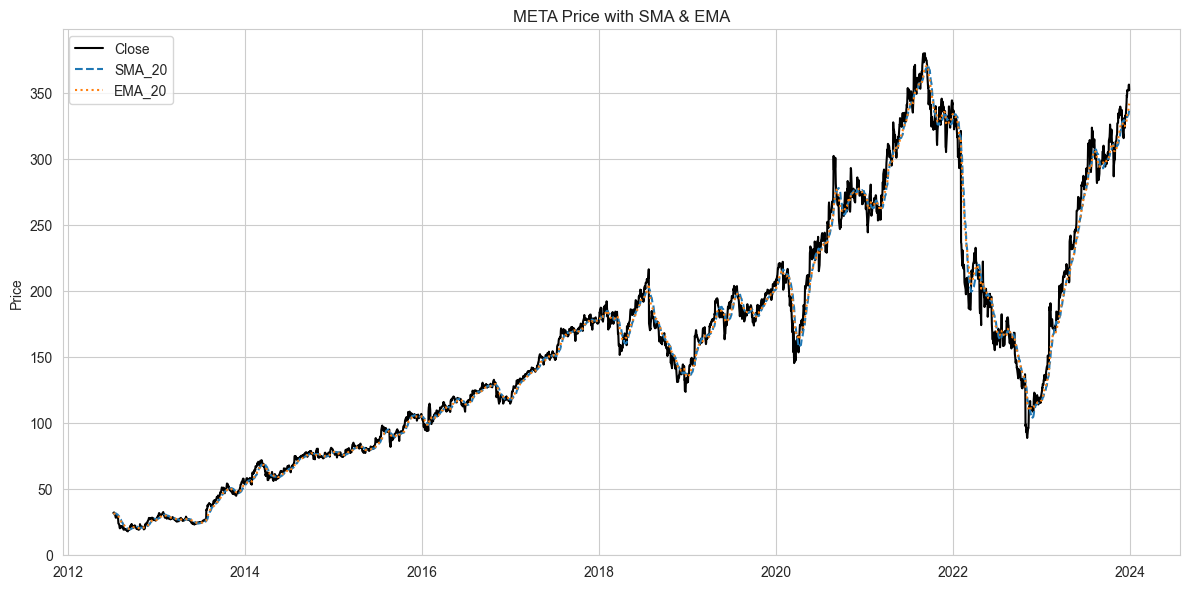

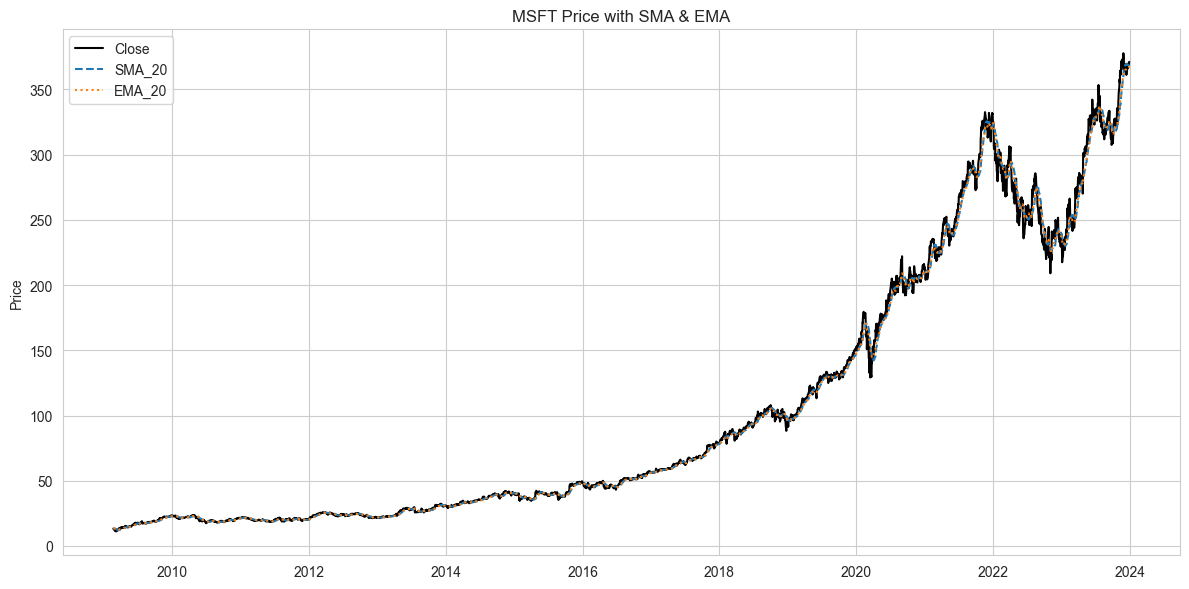

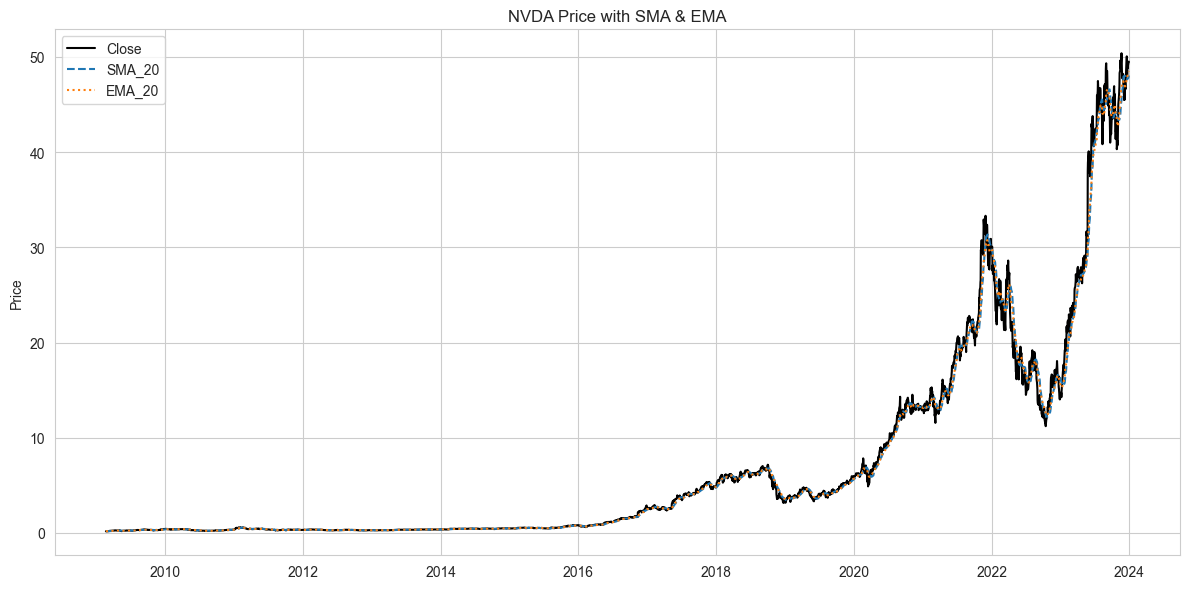

In [13]:
# -----------------------------
#  Quick sanity check plots for all assets
# -----------------------------
for ticker in ASSETS:
    df_plot = all_features[ticker]

    plot_price_with_indicators(
        df_plot,
        close_col="Close",
        sma_col="SMA_20",
        ema_col="EMA_20",
        title=f"{ticker} Price with SMA & EMA"
    )

    # Save plot
    plt.savefig(PLOTS_DIR / f"{ticker}_price_sma_ema.png",
                dpi=300, bbox_inches="tight")
    plt.close()

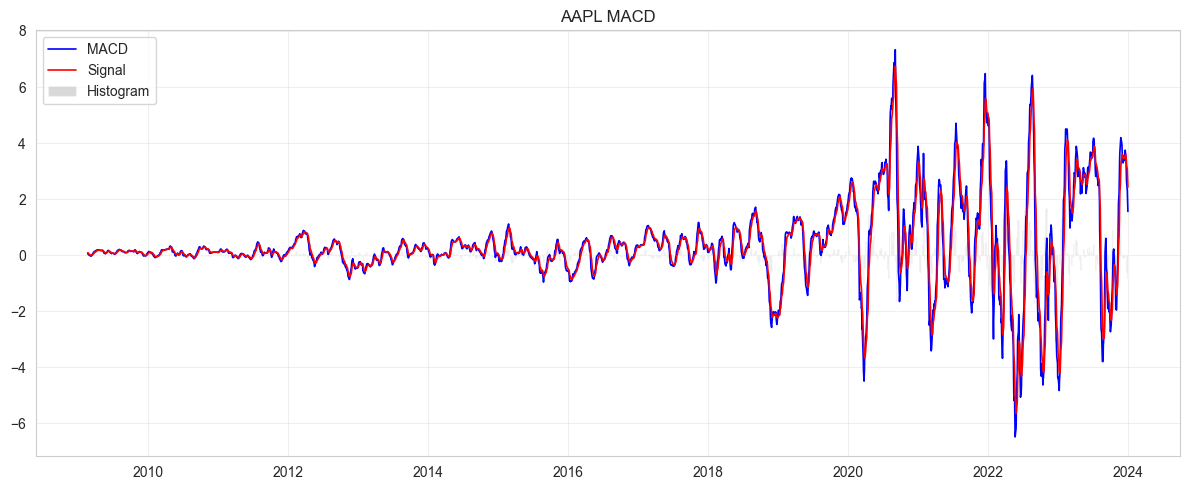

In [14]:
ticker = ASSETS[0]
df_plot = all_features[ticker]

plot_macd(
    df_plot,
    close_col="Close",
    macd_col="MACD_12_26_9",
    signal_col="MACD_signal_12_26_9",
    hist_col="MACD_hist_12_26_9",
    title=f"{ticker} MACD"
)

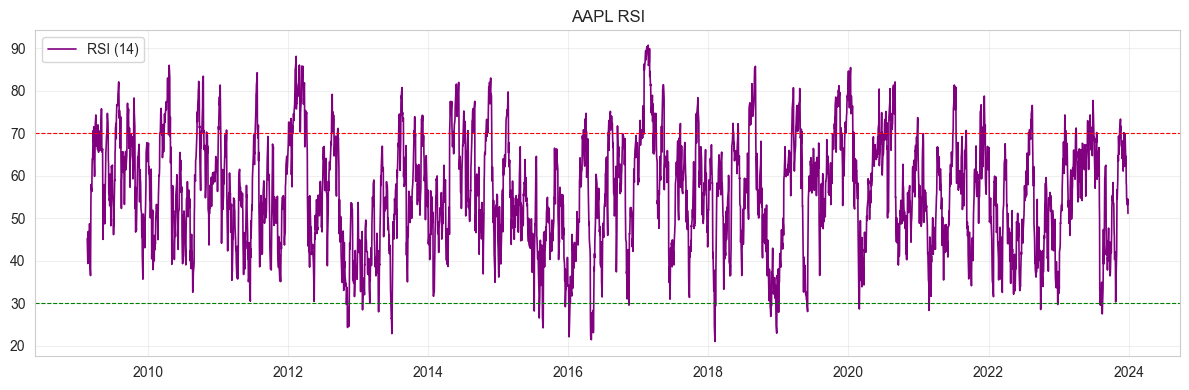

In [15]:
plot_rsi(
    all_features["AAPL"],
    close_col="Close",
    rsi_col="RSI_14",
    period=14,
    title=f"{ticker} RSI"
)

In [21]:
# -----------------------------
#  Save processed features for all assets
# -----------------------------
PROCESSED_DIR = project_root / "data" / "processed" / "prices"
print(PROCESSED_DIR)

for ticker, df in all_features.items():
    feature_file = PROCESSED_DIR / f"{ticker}_features.csv"
    df.to_csv(feature_file, index=True)
    logger.info(f"Saved features for {ticker} to {feature_file}")

D:\10Acadamy\Week 1\Task\Predicting-Price-Moves-with-News-Sentiment\data\processed\prices


2025-11-26 22:03:33,220 [INFO] __main__: Saved features for AAPL to D:\10Acadamy\Week 1\Task\Predicting-Price-Moves-with-News-Sentiment\data\processed\prices\AAPL_features.csv
2025-11-26 22:03:34,633 [INFO] __main__: Saved features for AMZN to D:\10Acadamy\Week 1\Task\Predicting-Price-Moves-with-News-Sentiment\data\processed\prices\AMZN_features.csv
2025-11-26 22:03:35,142 [INFO] __main__: Saved features for GOOG to D:\10Acadamy\Week 1\Task\Predicting-Price-Moves-with-News-Sentiment\data\processed\prices\GOOG_features.csv
2025-11-26 22:03:35,928 [INFO] __main__: Saved features for META to D:\10Acadamy\Week 1\Task\Predicting-Price-Moves-with-News-Sentiment\data\processed\prices\META_features.csv
2025-11-26 22:03:36,692 [INFO] __main__: Saved features for MSFT to D:\10Acadamy\Week 1\Task\Predicting-Price-Moves-with-News-Sentiment\data\processed\prices\MSFT_features.csv
2025-11-26 22:03:37,544 [INFO] __main__: Saved features for NVDA to D:\10Acadamy\Week 1\Task\Predicting-Price-Moves-with